In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import sys
sys.path.append("/home/bakingsoda/side/TABNET_simple")

In [97]:

import torch
device = torch.device("cpu")


In [98]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path
from matplotlib import pyplot as plt

In [99]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [100]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


In [101]:

train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [102]:
train.describe()

,39,77516,13,2174,0,40
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


# 전처리 

## 1. 결측치 대체
## 2. label encoding

In [103]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [104]:
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

In [105]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

14

In [106]:
cat_dims

[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]

In [107]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [108]:
input_dim = X_train.shape[1]
from utils_output import infer_output_dim
output_dim, train_labels = infer_output_dim(y_train)
classes_ = train_labels
target_mapper = {
    class_label: index for index, class_label in enumerate(classes_)
}
preds_mapper = {
    str(index): class_label for index, class_label in enumerate(classes_)
}


In [109]:
target_mapper , preds_mapper

({'not_wealthy': 0, 'wealthy': 1}, {'0': 'not_wealthy', '1': 'wealthy'})

In [110]:
from typing import List, Any, Dict
n_d: int = 8
n_a: int = 8
n_steps: int = 3
gamma: float = 1.3
cat_idxs: List[int] =cat_idxs
cat_dims: List[int] = cat_dims
cat_emb_dim: int = 1
n_independent: int = 2
n_shared: int = 2
epsilon: float = 1e-15
momentum: float = 0.02
lambda_sparse: float = 1e-3
seed: int = 0
clip_value: int = 1
verbose: int = 1
optimizer_fn: Any = torch.optim.Adam
optimizer_params: Dict = dict(lr=2e-2)
scheduler_fn: Any = None
scheduler_params: Dict = {"step_size":50,"gamma":0.9}
mask_type: str = "sparsemax"
input_dim: int = input_dim
output_dim: int = output_dim
device_name: str = "auto"

In [111]:
virtual_batch_size=128

In [112]:
from tab_network import TabNet
network = TabNet(
            input_dim,
            output_dim,
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=cat_emb_dim,
            n_independent=n_independent,
            n_shared=n_shared,
            epsilon=epsilon,
            virtual_batch_size=virtual_batch_size,
            momentum=momentum,
            mask_type=mask_type,
        ).to(device)

In [113]:
from utils_dataset import TorchDataset , PredictDataset

In [114]:
optim= optimizer_fn(network.parameters(),**optimizer_params)



In [115]:
from torch.utils.data import DataLoader
batch_size= 32
sampler= None
need_shuffle= True
num_workers = 3
drop_last= True
pin_memory=True

loss_fn = torch.nn.functional.cross_entropy

In [116]:
def prepare_target( y):
    return np.vectorize(target_mapper.get)(y)

y_train_mapped = prepare_target(y_train)
y_train_mapped

array([1, 1, 1, ..., 1, 1, 0])

In [117]:
train_dataloader = DataLoader(
        TorchDataset(X_train.astype(np.float32), y_train_mapped),
        batch_size=batch_size,
        sampler=sampler,
        shuffle=need_shuffle,
        num_workers=num_workers,
        drop_last=drop_last,
        pin_memory=pin_memory,
    )

In [118]:
network.train()
X, y=next(iter(train_dataloader))
X = X.to(device).float()
y = y.to(device).float()

for param in network.parameters():
    param.grad = None

output, M_loss = network(X)
loss = loss_fn(output , y.long())
loss -= lambda_sparse * M_loss
loss.backward()
optim.step()


In [119]:
network.train()
for epoch in range(10) :
    loss_ = 0
    for batch_idx , (X,y) in enumerate(train_dataloader) :
        X = X.to(device).float()
        y = y.to(device).float()

        for param in network.parameters():
            param.grad = None

        output, M_loss = network(X)
        loss = loss_fn(output , y.long())
        loss -= lambda_sparse * M_loss
        loss.backward()
        optim.step()
        loss_ += loss.detach().numpy()
    loss_ /= len(train_dataloader)
    print(f"EPOCH : {epoch} LOSS : {loss_:.5f}")

EPOCH : 0 LOSS : 0.43991
EPOCH : 1 LOSS : 0.37329
EPOCH : 2 LOSS : 0.35153
EPOCH : 3 LOSS : 0.34116
EPOCH : 4 LOSS : 0.34049
EPOCH : 5 LOSS : 0.33469
EPOCH : 6 LOSS : 0.32196
EPOCH : 7 LOSS : 0.30444
EPOCH : 8 LOSS : 0.29795
EPOCH : 9 LOSS : 0.29383


In [120]:
def predict_func(outputs):
    outputs = np.argmax(outputs, axis=1)
    return np.vectorize(preds_mapper.get)(outputs.astype(str))

In [121]:
predict_func(output.detach().numpy())

array(['wealthy', 'not_wealthy', 'wealthy', 'wealthy', 'not_wealthy',
       'not_wealthy', 'not_wealthy', 'wealthy', 'not_wealthy', 'wealthy',
       'wealthy', 'wealthy', 'wealthy', 'not_wealthy', 'wealthy',
       'wealthy', 'wealthy', 'not_wealthy', 'wealthy', 'wealthy',
       'wealthy', 'wealthy', 'wealthy', 'wealthy', 'not_wealthy',
       'wealthy', 'not_wealthy', 'wealthy', 'not_wealthy', 'wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

In [122]:
probs = torch.nn.Softmax(dim=1)(output).cpu().detach().numpy()
#probs

In [123]:
import scipy
def create_explain_matrix(input_dim, cat_emb_dim, cat_idxs, post_embed_dim):
    """
    This is a computational trick.
    In order to rapidly sum importances from same embeddings
    to the initial index.

    Parameters
    ----------
    input_dim : int
        Initial input dim
    cat_emb_dim : int or list of int
        if int : size of embedding for all categorical feature
        if list of int : size of embedding for each categorical feature
    cat_idxs : list of int
        Initial position of categorical features
    post_embed_dim : int
        Post embedding inputs dimension

    Returns
    -------
    reducing_matrix : np.array
        Matrix of dim (post_embed_dim, input_dim)  to performe reduce
    """

    if isinstance(cat_emb_dim, int):
        all_emb_impact = [cat_emb_dim - 1] * len(cat_idxs)
    else:
        all_emb_impact = [emb_dim - 1 for emb_dim in cat_emb_dim]

    acc_emb = 0
    nb_emb = 0
    indices_trick = []
    for i in range(input_dim):
        if i not in cat_idxs:
            indices_trick.append([i + acc_emb])
        else:
            indices_trick.append(
                range(i + acc_emb, i + acc_emb + all_emb_impact[nb_emb] + 1)
            )
            acc_emb += all_emb_impact[nb_emb]
            nb_emb += 1

    reducing_matrix = np.zeros((post_embed_dim, input_dim))
    for i, cols in enumerate(indices_trick):
        reducing_matrix[cols, i] = 1

    return scipy.sparse.csc_matrix(reducing_matrix)

reducing_matrix = create_explain_matrix(
            network.input_dim,
            network.cat_emb_dim,
            network.cat_idxs,
            network.post_embed_dim,
        )
reducing_matrix


<14x14 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Column format>

In [124]:
from scipy.sparse import csc_matrix
def _compute_feature_importances(loader):
    """Compute global feature importance.

    Parameters
    ----------
    loader : `torch.utils.data.Dataloader`
        Pytorch dataloader.

    """
    network.eval()
    feature_importances_ = np.zeros((network.post_embed_dim))
    for data, targets in loader:
        data = data.to(device).float()
        M_explain, masks = network.forward_masks(data)
        feature_importances_ += M_explain.sum(dim=0).cpu().detach().numpy()

    feature_importances_ = csc_matrix.dot(
        feature_importances_, reducing_matrix
    )
    feature_importances_ = feature_importances_ / np.sum(feature_importances_)
    return feature_importances_

In [125]:
features = [ col for col in train.columns if col not in unused_feat+[target]] 
fe_imp = _compute_feature_importances(train_dataloader)


In [126]:
feature = [feature.strip() for feature in features]

<AxesSubplot:>

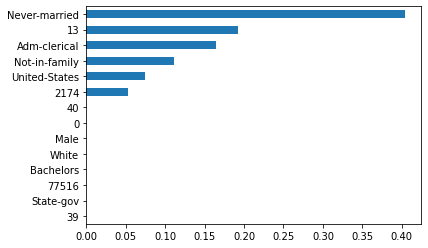

In [127]:
imp = pd.Series(fe_imp,index=feature)
imp.sort_values(ascending=True,inplace=True)
imp.plot.barh()

In [128]:
batch_size = 128
def explain( X):
    """
    Return local explanation

    Parameters
    ----------
    X : tensor: `torch.Tensor`
        Input data

    Returns
    -------
    M_explain : matrix
        Importance per sample, per columns.
    masks : matrix
        Sparse matrix showing attention masks used by network.
    """
    network.eval()

    dataloader = DataLoader(
        PredictDataset(X),
        batch_size=batch_size,
        shuffle=False,
    )

    res_explain = []

    for batch_nb, data in enumerate(dataloader):
        data = data.to(device).float()

        M_explain, masks = network.forward_masks(data)
        for key, value in masks.items():
            masks[key] = csc_matrix.dot(
                value.cpu().detach().numpy(), reducing_matrix
            )

        res_explain.append(
            csc_matrix.dot(M_explain.cpu().detach().numpy(), reducing_matrix)
        )

        if batch_nb == 0:
            res_masks = masks
        else:
            for key, value in masks.items():
                res_masks[key] = np.vstack([res_masks[key], value])

    res_explain = np.vstack(res_explain)

    return res_explain, res_masks

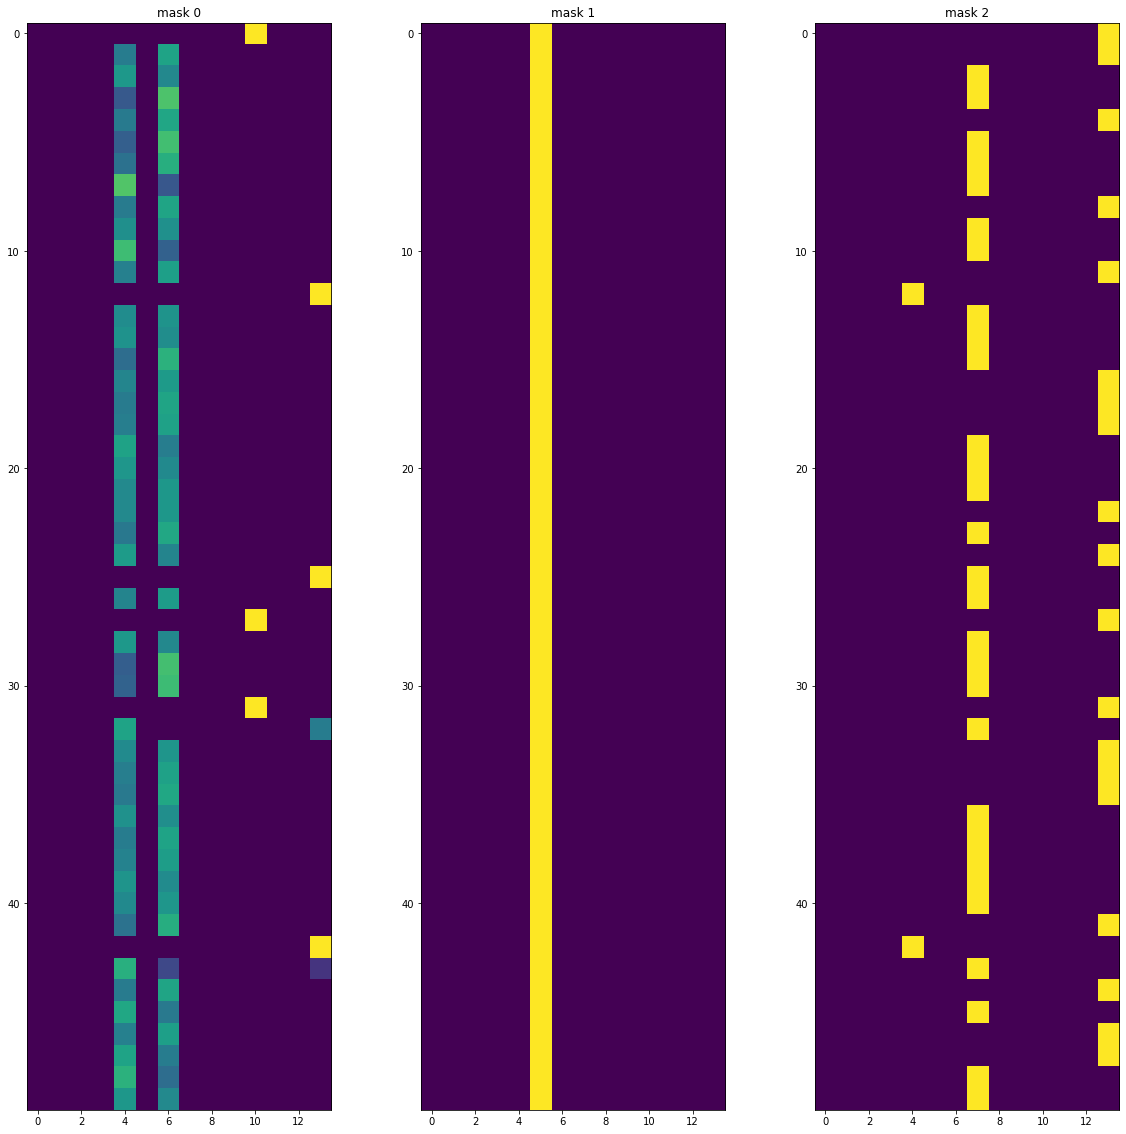

In [129]:
import matplotlib.pyplot as plt
explain_matrix, masks = explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")